In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Load parsed lightcurves
csv_path = 'parsed_lightcurves.csv'

In [ ]:
df = pd.read_csv(csv_path)
unique_labels = df['type'].unique()
label_map = {
    'acep_lc': 0,
    'cep_lc': 1,
    't2cep_lc': 2,
    'rrlyr_lc': 3,
    'lpv_lc': 4,
    'deltascuti_lc': 5,
    'hb_lc': 6,
    'tr_lc': 7,
    'ecl_lc': 8,
}
print("Label map:", label_map)

Label map: {'acep_lc': 0, 'cep_lc': 1, 't2cep_lc': 2, 'rrlyr_lc': 3, 'lpv_lc': 4, 'deltascuti_lc': 5, 'hb_lc': 6, 'tr_lc': 7, 'ecl_lc': 8}


In [ ]:
# Show shape and first few rows
print("Shape of full dataset:", df.shape)
print("\nSample rows:")
print(df.head())

Shape of full dataset: (7144318, 6)

Sample rows:
                  id     type band            jd     mag    err
0  OGLE-GAL-ACEP-001  acep_lc    I  2.456112e+06  14.577  0.005
1  OGLE-GAL-ACEP-001  acep_lc    I  2.456117e+06  14.514  0.005
2  OGLE-GAL-ACEP-001  acep_lc    I  2.456120e+06  14.609  0.005
3  OGLE-GAL-ACEP-001  acep_lc    I  2.456139e+06  14.158  0.005
4  OGLE-GAL-ACEP-001  acep_lc    I  2.456151e+06  14.239  0.005


In [ ]:
# Unique classes and counts
print("\nClass distribution:")
print(df['type'].value_counts())


Class distribution:
type
cep_lc           5323405
deltascuti_lc    1538822
acep_lc           204478
ecl_lc             77613
Name: count, dtype: int64


Create Sequence Dictionary

In [ ]:
def build_sequence_dict(df, band='I'):
    grouped = df[df['band'] == band].groupby('id')
    seq_dict = {}
    label_dict = {}

    for id_, group in grouped:
        seq = group.sort_values('jd')['mag'].values
        label = group['type'].values[0]
        seq_dict[id_] = seq
        label_dict[id_] = label

    return seq_dict, label_dict

seq_dict, label_dict = build_sequence_dict(df)

In [ ]:
label_encoder = LabelEncoder()
label_encoder.fit(list(set(label_dict.values())))
label_map = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label map:", label_map)

Label map: {np.str_('acep_lc'): np.int64(0), np.str_('cep_lc'): np.int64(1), np.str_('deltascuti_lc'): np.int64(2), np.str_('ecl_lc'): np.int64(3)}


In [ ]:
def prepare_data(percent=0.1, max_len=500):
    X, y = [], []
    for id_, seq in seq_dict.items():
        cut = max(1, int(len(seq) * percent))
        seq_cut = seq[:cut]
        padded = pad_sequences([seq_cut], maxlen=max_len, dtype='float32', padding='post', truncating='post')[0]
        X.append(padded)
        y.append(label_map[label_dict[id_]])

    X = np.expand_dims(np.array(X), axis=-1)
    y = to_categorical(y, num_classes=len(label_map))
    return train_test_split(X, y, test_size=0.2, random_state=42)

LSTM Builder

In [ ]:
def build_model(input_shape, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.Masking(mask_value=0.0, input_shape=input_shape),
        tf.keras.layers.LSTM(64, return_sequences=False),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

Training and Evaluation

In [ ]:
percentages = [0.1, 0.2, 0.5]
results = {}

In [ ]:
for pct in percentages:
    print(f"\n=== Training for {int(pct*100)}% of lightcurve ===")
    X_train, X_test, y_train, y_test = prepare_data(percent=pct, max_len=500)

    model = build_model(X_train.shape[1:], y_train.shape[1])
    history = model.fit(X_train, y_train, epochs=5, batch_size=128, validation_data=(X_test, y_test), verbose=1)

    y_pred = model.predict(X_test)
    y_true = np.argmax(y_test, axis=1)
    y_pred_labels = np.argmax(y_pred, axis=1)

    report = classification_report(y_true, y_pred_labels, output_dict=True)
    auc = roc_auc_score(y_test, y_pred, multi_class='ovr')

    results[int(pct*100)] = {
        'classification_report': report,
        'roc_auc': auc
    }

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred_labels))
    print("ROC-AUC:", auc)



=== Training for 10% of lightcurve ===


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.7841 - loss: 0.7081 - val_accuracy: 0.8704 - val_loss: 0.4407
Epoch 2/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 69s 872ms/step - accuracy: 0.8735 - loss: 0.4382 - val_accuracy: 0.8866 - val_loss: 0.3786
Epoch 3/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 86s 946ms/step - accuracy: 0.8874 - loss: 0.3600 - val_accuracy: 0.8704 - val_loss: 0.3940
Epoch 4/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 84s 973ms/step - accuracy: 0.8786 - loss: 0.3865 - val_accuracy: 0.9051 - val_loss: 0.3263
Epoch 5/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.9032 - loss: 0.3346 - val_accuracy: 0.9086 - val_loss: 0.3080
72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        73
           1       0.92      0.99      0.95      1981
           2       0.70      0.56      0.62       202
           3       0.00      0.00      0.00        20

    accuracy                  

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

Epoch 1/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 71s 945ms/step - accuracy: 0.6654 - loss: 0.8945 - val_accuracy: 0.8704 - val_loss: 0.4347
Epoch 2/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 83s 962ms/step - accuracy: 0.8711 - loss: 0.4096 - val_accuracy: 0.8919 - val_loss: 0.3453
Epoch 3/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 82s 956ms/step - accuracy: 0.8872 - loss: 0.3617 - val_accuracy: 0.9038 - val_loss: 0.3258
Epoch 4/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 78s 908ms/step - accuracy: 0.8987 - loss: 0.3406 - val_accuracy: 0.8976 - val_loss: 0.3370
Epoch 5/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 84s 935ms/step - accuracy: 0.9015 - loss: 0.3350 - val_accuracy: 0.9042 - val_loss: 0.3188
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m


Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        73
           1       0.94      0.97      0.95      1981
           2       0.59      0.67      0.63       202
           3       0.00      0.00      0.00        20

    accuracy                           0.90      2276
   macro avg       0.38      0.41      0.40      2276
weighted avg       0.87      0.90      0.89      2276

ROC-AUC: 0.8782135423712902

=== Training for 50% of lightcurve ===
Epoch 1/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 71s 937ms/step - accuracy: 0.8590 - loss: 0.5908 - val_accuracy: 0.8774 - val_loss: 0.3859
Epoch 2/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 84s 966ms/step - accuracy: 0.8739 - loss: 0.3730 - val_accuracy: 0.9007 - val_loss: 0.3309
Epoch 3/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 80s 951ms/step - accuracy: 0.9055 - loss: 0.3241 - val_accuracy: 0.8704 - val_loss: 0.3702
Epoch 4/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 83s 971ms/step - accuracy: 0.8934 - loss: 0.3558 - v

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

In [1]:
import numpy as np
import pandas as pd

# Assume y_true, y_pred_labels, and y_pred are already computed
for pct in percentages:
    print(f"\n=== Saving data for {int(pct*100)}% of lightcurve ===")

    # Prepare the results (already computed during your training loop)
    y_true = np.argmax(y_test, axis=1)
    y_pred_labels = np.argmax(y_pred, axis=1)

    # Store the data into a DataFrame or Numpy file
    df = pd.DataFrame({
        'y_true': y_true,
        'y_pred_labels': y_pred_labels,
        'y_pred': y_pred.tolist()  # Save probabilities as a list
    })

    # Save it into a file (use CSV or Numpy, depending on preference)
    df.to_csv(f"predictions_{int(pct*100)}%.csv", index=False)  # or .npy for Numpy arrays


NameError: name 'percentages' is not defined

RNN

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Masking
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Map string labels to integers
label_map = {
    'acep_lc': 0,
    'cep_lc': 1,
    't2cep_lc': 2,
    'rr_lc': 3,
    'mira_lc': 4,
    'deltascuti_lc': 5,
    'heartbeat_lc': 6,
    'ecl_lc': 7,
}
df['label'] = df['type'].map(label_map)

In [ ]:
# Group by star id
sequences = []
labels = []

for id, group in df.groupby("id"):
    seq = group.sort_values("jd")["mag"].values
    label = group["label"].values[0]
    sequences.append(seq)
    labels.append(label)


In [ ]:
MAX_LEN = 300  # or adjust as needed
PAD_VALUE = 0.0

In [ ]:
i_band_sequences = []
i_band_labels = []

grouped = df[df['band'] == 'I'].groupby('id')

for star_id, group in grouped:
    sequence = group.sort_values('jd')['mag'].tolist()
    label = group['type'].iloc[0]
    if len(sequence) > 0:
        i_band_sequences.append(sequence)
        i_band_labels.append(label)

In [ ]:
# Padding and encoding
X = pad_sequences(i_band_sequences, maxlen=MAX_LEN, dtype='float32',
                  padding='post', truncating='post', value=PAD_VALUE)
X = X[..., np.newaxis]

In [ ]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(i_band_labels)
y = to_categorical(y_encoded)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Define model
model = Sequential()
model.add(Masking(mask_value=PAD_VALUE, input_shape=(MAX_LEN, 1)))
model.add(SimpleRNN(64, return_sequences=False))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Setup early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
# Train
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    callbacks=[early_stop]
)

Epoch 1/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 22s 117ms/step - accuracy: 0.7893 - loss: 0.6200 - val_accuracy: 0.8994 - val_loss: 0.3389
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 17s 116ms/step - accuracy: 0.9022 - loss: 0.3284 - val_accuracy: 0.8989 - val_loss: 0.3314
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 118ms/step - accuracy: 0.9098 - loss: 0.3115 - val_accuracy: 0.9038 - val_loss: 0.3136
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 22s 127ms/step - accuracy: 0.9134 - loss: 0.2976 - val_accuracy: 0.9038 - val_loss: 0.3087
Epoch 5/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 19s 116ms/step - accuracy: 0.9102 - loss: 0.3073 - val_accuracy: 0.9029 - val_loss: 0.3096
Epoch 6/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 123ms/step - accuracy: 0.9131 - loss: 0.2968 - val_accuracy: 0.8985 - val_loss: 0.3360
Epoch 7/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 19s 116ms/step - accuracy: 0.9129 - loss: 0.2873 - val_accuracy: 0.9038 - val_loss: 0.3112


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# y_train is one‑hot; convert back to integer labels
y_train_int = np.argmax(y_train, axis=1)

# Compute balanced class weights
classes = np.unique(y_train_int)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_int)

# Make into dict: {class_index: weight}
class_weight = dict(zip(classes, weights))
print("Class weights:", class_weight)

Class weights: {np.int64(0): np.float64(7.246815286624204), np.int64(1): np.float64(0.28658690176322416), np.int64(2): np.float64(2.851503759398496), np.int64(3): np.float64(45.51)}


In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    class_weight=class_weight,
    callbacks=[early_stop]
)

Epoch 1/20


Exception ignored in: <function _xla_gc_callback at 0x7f070c092480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
    
KeyboardInterrupt: 


143/143 ━━━━━━━━━━━━━━━━━━━━ 97s 118ms/step - accuracy: 0.5822 - loss: 1.4450 - val_accuracy: 0.5488 - val_loss: 1.1256
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 17s 117ms/step - accuracy: 0.6655 - loss: 1.1554 - val_accuracy: 0.6516 - val_loss: 1.0101
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 117ms/step - accuracy: 0.6884 - loss: 1.1486 - val_accuracy: 0.8554 - val_loss: 0.5550
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 20s 115ms/step - accuracy: 0.7142 - loss: 1.0898 - val_accuracy: 0.5782 - val_loss: 1.1180
Epoch 5/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 121ms/step - accuracy: 0.6993 - loss: 1.1547 - val_accuracy: 0.8686 - val_loss: 0.6092
Epoch 6/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 17s 115ms/step - accuracy: 0.7877 - loss: 1.0437 - val_accuracy: 0.5725 - val_loss: 1.0760


In [ ]:
loss, acc = model.evaluate(X_val, y_val)
print(f"\nValidation Accuracy: {acc:.4f}")

72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.8657 - loss: 0.5436

Validation Accuracy: 0.8554


In [ ]:
# Predict classes
y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_val, axis=1)

72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step


In [ ]:
# Classification report
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

               precision    recall  f1-score   support

      acep_lc       0.15      0.41      0.22        73
       cep_lc       0.95      0.96      0.96      1981
deltascuti_lc       0.00      0.00      0.00       202
       ecl_lc       0.12      0.40      0.19        20

     accuracy                           0.86      2276
    macro avg       0.31      0.44      0.34      2276
 weighted avg       0.83      0.86      0.84      2276



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


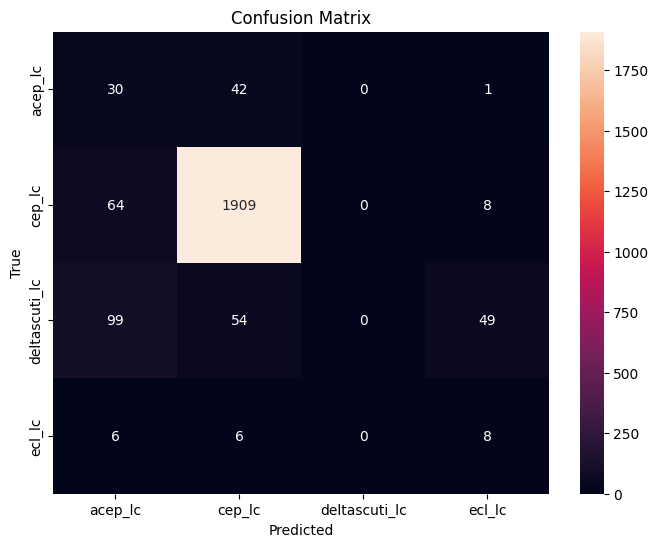

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

               precision    recall  f1-score   support

      acep_lc       0.15      0.41      0.22        73
       cep_lc       0.95      0.96      0.96      1981
deltascuti_lc       0.00      0.00      0.00       202
       ecl_lc       0.12      0.40      0.19        20

     accuracy                           0.86      2276
    macro avg       0.31      0.44      0.34      2276
 weighted avg       0.83      0.86      0.84      2276



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import numpy as np
from collections import Counter

def oversample_data(X, y):
    y_labels = np.argmax(y, axis=1)
    class_counts = Counter(y_labels)
    max_count = max(class_counts.values())

    X_oversampled, y_oversampled = [], []

    for class_label in class_counts:
        idxs = np.where(y_labels == class_label)[0]
        X_class = X[idxs]
        y_class = y[idxs]

        n_to_add = max_count - len(X_class)
        if n_to_add > 0:
            extra_idxs = np.random.choice(len(X_class), n_to_add, replace=True)
            X_extra = X_class[extra_idxs]
            y_extra = y_class[extra_idxs]

            X_class = np.concatenate([X_class, X_extra])
            y_class = np.concatenate([y_class, y_extra])

        X_oversampled.append(X_class)
        y_oversampled.append(y_class)

    return np.concatenate(X_oversampled), np.concatenate(y_oversampled)

# Just call this before training
X_train_balanced, y_train_balanced = oversample_data(X_train, y_train)

In [ ]:
loss, acc = model.evaluate(X_val, y_val)
print(f"\nValidation Accuracy: {acc:.4f}")

72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9095 - loss: 0.2876

Validation Accuracy: 0.9038


In [ ]:
# Predict classes
y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_val, axis=1)

72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step


In [ ]:
# Classification report
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

               precision    recall  f1-score   support

      acep_lc       0.00      0.00      0.00        73
       cep_lc       0.94      0.97      0.95      1981
deltascuti_lc       0.60      0.63      0.62       202
       ecl_lc       0.00      0.00      0.00        20

     accuracy                           0.90      2276
    macro avg       0.38      0.40      0.39      2276
 weighted avg       0.87      0.90      0.89      2276



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


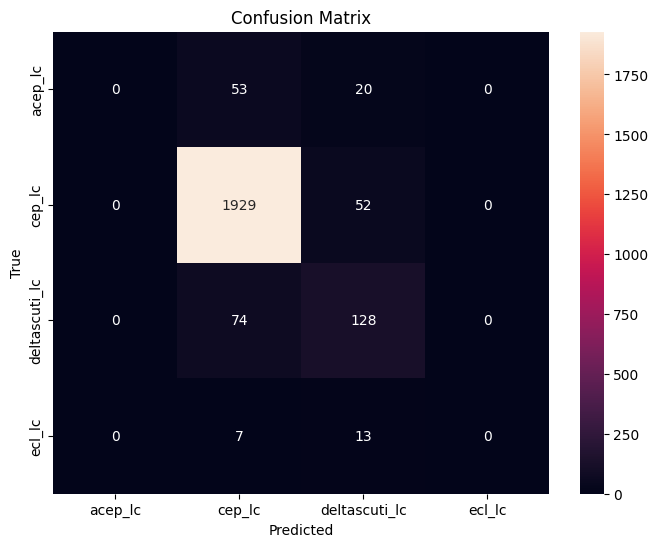

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()